# Emerging Technologies Project

The following notebook trains a model that can be used to predict power output from wind speed values, as defined in the `powerproduction` dataset.

## Preamble

I'll begin by importing the necessary packages and reading in the dataset.

In [1]:
import tensorflow.keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Plot style
plt.style.use("ggplot")

# Plot size
plt.rcParams["figure.figsize"] = [14, 8]

In [3]:
# Read in the dataset
df = pd.read_csv("./powerproduction.csv")

# Print the first few rows
df.head(8)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826


Next I'll partition the dataset it into two subsets. The first will be used to fit the model and is referred to as the training dataset, while the second will instead be used to make predictions based on the training data. The objective of splitting the data is to provide a way to estimate the performance of the machine learning model when it is presented with new data, i.e. data that wasn't used to train the model [1].

The training set will make up 80% of the total items in the overall dataset.

In [4]:
# Create train and test sets
# Reference: TensorFlow documentation
# https://www.tensorflow.org/tutorials/keras/regression#split_the_data_into_train_and_test
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

print("Training:")
print(train.head())
print("\nTesting:")
print(test.head())

Training:
      speed    power
90    4.905    7.060
254  12.713   51.149
283  14.489   71.763
445  22.422   99.357
461  23.273  113.556

Testing:
    speed  power
9   0.526  5.553
25  1.051  2.085
28  1.151  1.208
31  1.301  0.000
32  1.401  4.156


In order to better visualise the training and testing data sets we can plot them both using Matplotlib.

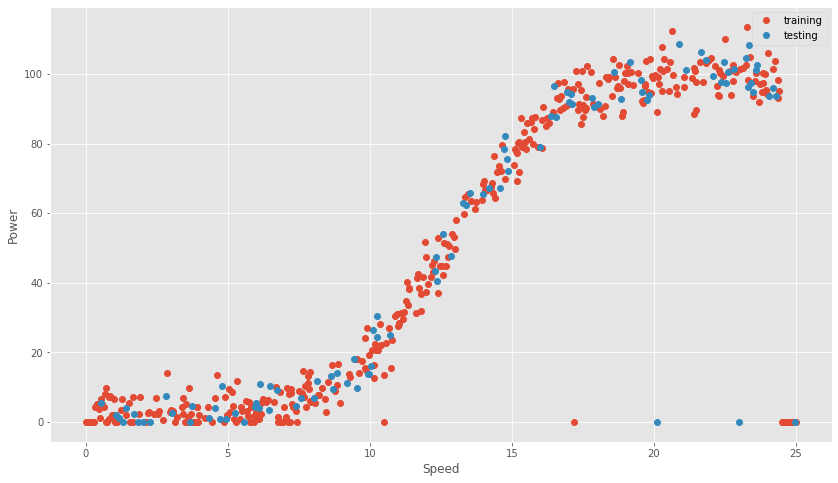

In [5]:
plt.plot(
    train.speed,
    train.power,
    "o",
    label="training"
)

plt.plot(
    test.speed, 
    test.power,
    "o",
    label="testing"
)

plt.xlabel("Speed")
plt.ylabel("Power")

plt.legend();

When plotting the data, we'll notice that there are some outliers that may reduce the accuracy of our model. One possibility for these values could be maintenance work. However, an article from the US Office of Energy Efficiency and Renewable Energy suggests that as wind speed increases, wind turbines generate more power until a limit is reached, known as the rated speed [2]. By looking at the plot above, the maximum power output observed appears to be approximately 100 with a speed of around 20-25.

Once the rated speed is reached, the power output should remain relatively stable until eventually a cut-out speed is reached, whereupon the turbine will shut down to prevent damage [2]. This could provide an explanation for the cluster of zero values that appear as the speed approaches a value of 25.

## Creating a Linear Model

Now I'll construct a linear modal and attempt to use it in order to make predictions. This is done below using Keras' `Sequential` class, which represents a linear grouping of layers [3]. The model created below contains a single dense layer. A dense layer is a layer in neural network that’s fully connected, meaning all the neurons in one layer are connected to all other neurons in the next layer [3].

In [6]:
model = kr.models.Sequential()

# Add a single dense layer
model.add(
    kr.layers.Dense(
        1,
        input_shape=(1,),
        activation="linear",
        kernel_initializer="ones",
        bias_initializer="zeros"
    )
)

# Compile the model
model.compile("adam", loss="mean_squared_error")

In [7]:
# Train the neural network on the training data
model.fit(
    train.speed,
    train.power,
    epochs=200,
    batch_size=10
)

Epoch 1/200
40/40 [==============================] - 0s 718us/step - loss: 2468.3661
Epoch 2/200
40/40 [==============================] - 0s 948us/step - loss: 2455.6203
Epoch 3/200
40/40 [==============================] - 0s 744us/step - loss: 2334.8171
Epoch 4/200
40/40 [==============================] - 0s 1ms/step - loss: 2381.6278
Epoch 5/200
40/40 [==============================] - 0s 1000us/step - loss: 2251.9415
Epoch 6/200
40/40 [==============================] - 0s 795us/step - loss: 2404.7379
Epoch 7/200
40/40 [==============================] - 0s 693us/step - loss: 2295.9958
Epoch 8/200
40/40 [==============================] - 0s 924us/step - loss: 2110.5425
Epoch 9/200
40/40 [==============================] - 0s 974us/step - loss: 2202.3769
Epoch 10/200
40/40 [==============================] - 0s 744us/step - loss: 1967.2027
Epoch 11/200
40/40 [==============================] - 0s 407us/step - loss: 1931.4455
Epoch 12/200
40/40 [==============================] - 0s 1ms/ste

Epoch 97/200
40/40 [==============================] - 0s 814us/step - loss: 566.4370
Epoch 98/200
40/40 [==============================] - 0s 401us/step - loss: 572.8824
Epoch 99/200
40/40 [==============================] - 0s 801us/step - loss: 455.8305
Epoch 100/200
40/40 [==============================] - 0s 401us/step - loss: 587.4432
Epoch 101/200
40/40 [==============================] - 0s 801us/step - loss: 510.1701
Epoch 102/200
40/40 [==============================] - 0s 568us/step - loss: 518.0331
Epoch 103/200
40/40 [==============================] - 0s 400us/step - loss: 561.3934
Epoch 104/200
40/40 [==============================] - 0s 401us/step - loss: 577.7067
Epoch 105/200
40/40 [==============================] - 0s 401us/step - loss: 545.8087
Epoch 106/200
40/40 [==============================] - 0s 969us/step - loss: 575.3289
Epoch 107/200
40/40 [==============================] - 0s 401us/step - loss: 457.6017
Epoch 108/200
40/40 [==============================] - 0s

Epoch 192/200
40/40 [==============================] - 0s 513us/step - loss: 454.1336
Epoch 193/200
40/40 [==============================] - 0s 692us/step - loss: 587.9570
Epoch 194/200
40/40 [==============================] - 0s 487us/step - loss: 474.0772
Epoch 195/200
40/40 [==============================] - 0s 538us/step - loss: 495.4302
Epoch 196/200
40/40 [==============================] - 0s 590us/step - loss: 461.2281
Epoch 197/200
40/40 [==============================] - 0s 564us/step - loss: 479.3671
Epoch 198/200
40/40 [==============================] - 0s 513us/step - loss: 609.7308
Epoch 199/200
40/40 [==============================] - 0s 538us/step - loss: 564.6143
Epoch 200/200
40/40 [==============================] - 0s 310us/step - loss: 527.2872


### Analysis

Now that the training process is complete, the model can be used to make predictions. First I'll visualise the results by plotting the values from the `train` dataset alongside the predicted values of each point in the `test` dataset. I'll create a function for this since I'm going to be reusing a lot of the below code throughout the notebook.

In [8]:
def plot_predictions(pred_speed=None, pred_power=None):
    """
    Creates a plot of the training dataset alongside the predicted values of each point
    in the test dataset.
    
    :param float pred_speed: Can be used to plot a specific predicted speed value.
    :param float pred_power: Can be used to plot a specific predicted power value.
    """
    # Plot the training dataset
    plt.plot(
        train.speed,
        train.power,
        "o",
        label="actual"
    )

    # Plot the predictions from the `test` dataset
    plt.plot(
        test.speed, 
        model.predict(test.speed),
        label="predictions"
    )
    
    if pred_speed is not None and pred_power is not None:
        # Show the prediction location on the plot
        # Ref: https://www.mathworks.com/matlabcentral/answers/430336-draw-lines-from-both-axis-to-point-in-plot
        plt.plot(pred_speed, pred_power, "ko")
        plt.plot([pred_speed, pred_speed], [0, pred_power], "k-")
        plt.plot([0, pred_speed], [pred_power, pred_power], "k-")

    plt.xlabel("Speed")
    plt.ylabel("Power")

    plt.legend();

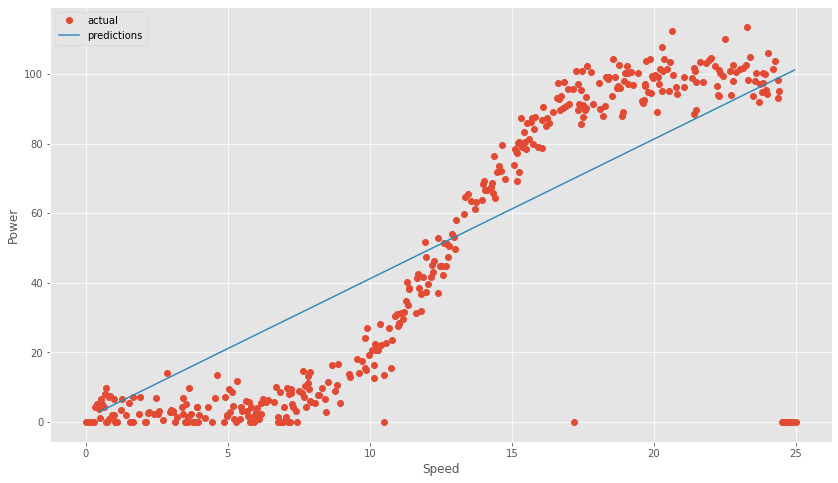

In [9]:
plot_predictions()

We can also predict individual values using Keras' `model.predict()` function. Below I find the predicted power output if the speed is 20, and then show where the result appears on the plot.

In [10]:
# Take a hand-picked speed value and view its predicted power
pred_speed = 20.0
pred_power = model.predict([pred_speed])[0]

pred_power

array([81.270744], dtype=float32)

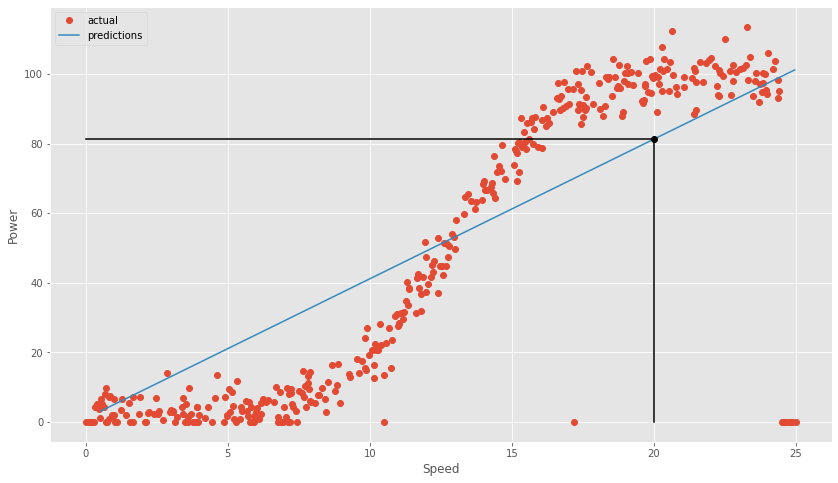

In [11]:
plot_predictions(pred_speed, pred_power)

As illustrated above, if we attempt to predict the power when the wind speed is 20, we get a value that is much lower than what we would expect. This is because the data in our dataset is not quite linear, and therefore linear regression is not the best form of regression to perform if we want to make more accurate predictions.

## Non-Linear Regression

Linear regression assumes that the relationship between an independent variable $x$ and a dependent variable $y$ can be best expressed with a line [4]. However, because the `powerproduction` dataset is non-linear, it would make more sense to do polynomial regression. Polynomial regression expresses the relationship between two variables as a polynomial curve [4].

Below I'll rebuild the model, this time using the *sigmoid* activation function. An activation function is simply a mathematical function that takes in an input and produces an output [5]. The function is activated when the computed result reaches a specified threshold and the output is then passed onto the neurons on the subsequent layer [5]. Like the shape of the `powerproduction` dataset, the sigmoid activation function is "S" shaped [5], making it the ideal choice for our model.

In [12]:
# Re-build the model
model = kr.models.Sequential()

model.add(
    kr.layers.Dense(
        64,
        input_shape=(1,),
        activation="sigmoid",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform"
    )
)

model.add(
    kr.layers.Dense(
        64,
        activation="sigmoid",
    )
)

model.add(kr.layers.Dense(1, activation="linear"))

model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error")

In [13]:
# Fit the data
model.fit(
    train.speed,
    train.power,
    epochs=200,
    batch_size=8
)

Epoch 1/200
50/50 [==============================] - 0s 638us/step - loss: 3981.0356
Epoch 2/200
50/50 [==============================] - 0s 771us/step - loss: 3543.0251
Epoch 3/200
50/50 [==============================] - 0s 638us/step - loss: 3106.4354
Epoch 4/200
50/50 [==============================] - 0s 957us/step - loss: 3178.7074
Epoch 5/200
50/50 [==============================] - 0s 639us/step - loss: 3067.7451
Epoch 6/200
50/50 [==============================] - 0s 956us/step - loss: 2808.7088
Epoch 7/200
50/50 [==============================] - 0s 771us/step - loss: 2439.3223
Epoch 8/200
50/50 [==============================] - 0s 769us/step - loss: 2730.8884
Epoch 9/200
50/50 [==============================] - 0s 638us/step - loss: 2902.4710
Epoch 10/200
50/50 [==============================] - 0s 954us/step - loss: 2511.2207
Epoch 11/200
50/50 [==============================] - 0s 638us/step - loss: 2333.0517
Epoch 12/200
50/50 [==============================] - 0s 452us/

50/50 [==============================] - 0s 638us/step - loss: 275.8554
Epoch 98/200
50/50 [==============================] - 0s 638us/step - loss: 189.7149
Epoch 99/200
50/50 [==============================] - 0s 770us/step - loss: 209.8853
Epoch 100/200
50/50 [==============================] - 0s 638us/step - loss: 264.6864
Epoch 101/200
50/50 [==============================] - 0s 638us/step - loss: 249.5322
Epoch 102/200
50/50 [==============================] - 0s 766us/step - loss: 329.7978
Epoch 103/200
50/50 [==============================] - 0s 638us/step - loss: 234.7476
Epoch 104/200
50/50 [==============================] - 0s 637us/step - loss: 211.4836
Epoch 105/200
50/50 [==============================] - 0s 771us/step - loss: 182.5474
Epoch 106/200
50/50 [==============================] - 0s 319us/step - loss: 340.9309
Epoch 107/200
50/50 [==============================] - 0s 319us/step - loss: 223.2266
Epoch 108/200
50/50 [==============================] - 0s 319us/step -

50/50 [==============================] - 0s 438us/step - loss: 118.8934
Epoch 193/200
50/50 [==============================] - 0s 638us/step - loss: 161.1162
Epoch 194/200
50/50 [==============================] - 0s 638us/step - loss: 210.4841
Epoch 195/200
50/50 [==============================] - 0s 648us/step - loss: 231.0950
Epoch 196/200
50/50 [==============================] - 0s 638us/step - loss: 220.8688
Epoch 197/200
50/50 [==============================] - 0s 638us/step - loss: 193.4647
Epoch 198/200
50/50 [==============================] - 0s 613us/step - loss: 191.7761
Epoch 199/200
50/50 [==============================] - 0s 592us/step - loss: 225.7692
Epoch 200/200
50/50 [==============================] - 0s 531us/step - loss: 253.8550


### Analysis

Once again, we can use this newly created model to make predictions. As done previously, I'll plot the values of the `train` dataset along with the predicted values of each point in the `test` dataset. Doing so, we'll find the predicted values appear to form a curved line.

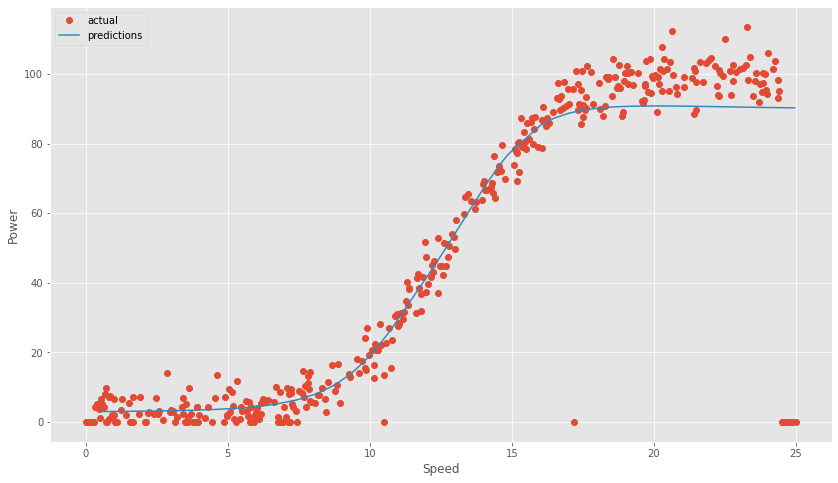

In [14]:
plot_predictions()

Again, we can provide an input speed of 20 to Keras' `model.predict()` function and plot the result.

In [15]:
pred_power = model.predict([pred_speed])[0]

pred_power

array([90.78553], dtype=float32)

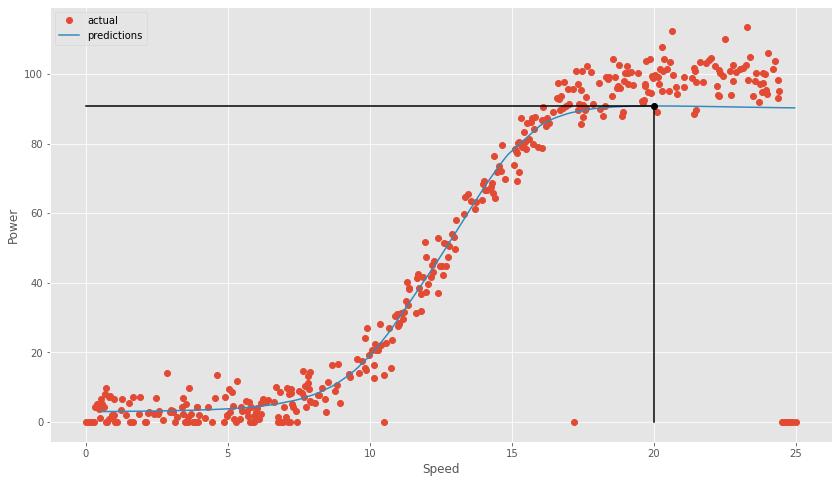

In [16]:
plot_predictions(pred_speed, pred_power)

We see that the result when using non-linear regression is much more accurate compared to the linear model tested previously.

## Saving the Model

We can use `model.save()` to easily save the model for later use in the web application.

In [17]:
model.save("power_prod.h5")

## References

1. [Train-Test Split for Evaluating Machine Learning Algorithms](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). Jason Brownlee. Machine Learning Mastery.
2. [How Do Wind Turbines Survive Severe Storms?](https://www.energy.gov/eere/articles/how-do-wind-turbines-survive-severe-storms). US Office of Energy Efficiency & Renewable Energy.
3. [Linear Regression using Keras and Python](https://heartbeat.fritz.ai/linear-regression-using-keras-and-python-7cee2819a60c). Dhiraj K. Heartbeat.
4. [Polynomial Regression using tf.keras](https://medium.com/@anigasan637/polynomial-regression-using-tf-keras-17eaac771256). Ananya Gangavarapu. Medium.
5. [Neural Network Activation Function Types](https://medium.com/fintechexplained/neural-network-activation-function-types-a85963035196). Farhad Malik. Medium.